
Goal
+ replicate some impl of entropic regularized ot
    + sinknhorn knopp
    + log domain
+ examples 
    + 1d gaussian 
    + point clouds
+ some reference impl 
    + https://github.com/gpeyre/SinkhornAutoDiff
    + https://github.com/zsteve/OptimalTransport.jl/blob/master/src/OptimalTransport.jl


In [1]:
import SinkhornAutoDiff as spc

import numpy as onp
import jax
import jax.numpy as np
import jax.random as random
from functools import partial


import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')


import ot
import ot.plot
from ot.datasets import make_1D_gauss

import sys
sys.path.insert(0,'../gp/')
from gpax import *
from plt_utils import *

from otax import *

Sinkhorn loss : 0.585


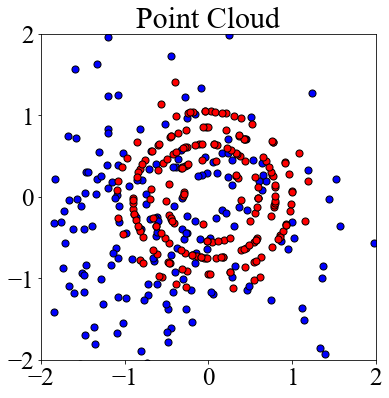

In [2]:

n = 200
N = [n,n] # Number of points per cloud


key = random.PRNGKey(0)
x = random.normal(key, (2,N[0]))-.5
theta = 2*np.pi*random.normal(key,(1,N[1]))
r = .8 + .2*random.normal(key,(1,N[1]))
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))


plt.figure(figsize=(6,6))
plt.scatter(x[0,:], x[1,:], s=50, edgecolors="k", c='b', linewidths=1)
plt.scatter(y[0,:], y[1,:], s=50, edgecolors="k", c='r', linewidths=1)
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.title("Point Cloud")

# Sinkhorn parameters
epsilon = 0.01
niter = 100

# # Wrap with torch tensors
import torch
X = torch.FloatTensor(onp.array(x.T))
Y = torch.FloatTensor(onp.array(y.T))

P1,l1 = spc.sinkhorn_loss(X,Y,epsilon,n,niter)
# P2,l2 = spc.sinkhorn_normalized(X,Y,epsilon,n,niter)

print(f"Sinkhorn loss : {l1.item():.3f}")
# print("Sinkhorn loss (normalized) : ", l2.data[0])
plt.show()


In [5]:
from jax.scipy.special import logsumexp

# @jax.jit
# def lse(x, axis=None, keepdims=False):
#     """y = c + logΣᵢexp(xᵢ-c) where c = max(x) 
#         Reference
#             - https://github.com/scipy/scipy/blob/v1.6.3/scipy/special/_logsumexp.py#L7-L127
#     """
#     c = np.amax(x, axis=axis, keepdims=True)
#     y = np.log(np.sum(np.exp(x - c), axis=axis, keepdims=keepdims))
#     if not keepdims: c = np.squeeze(c, axis=axis)
#     y += c
#     return y


# from scipy.special import logsumexp

a = np.array([1,2])*1e-10
b = np.array([-1,1])*1e-10
a,b,np.expand_dims(a,axis=1).shape, np.expand_dims(b,axis=0).shape


c = np.expand_dims(a,axis=1) * np.expand_dims(b,axis=0)

logsumexp(c, axis=0), lse(c, axis=0)

# np.max(c, axis=0)



(DeviceArray([-0.6867384,  2.3132615], dtype=float32),
 DeviceArray([-0.6867384,  2.3132615], dtype=float32))

In [ ]:



def lse(x, axis=None, keepdims=False):
    """y = c + logΣᵢexp(xᵢ-c) where c = max(x) 
        Reference
            - https://github.com/scipy/scipy/blob/v1.6.3/scipy/special/_logsumexp.py#L7-L127
    """
    c = np.amax(x, axis=axis, keepdims=True)
    y = np.log(np.sum(np.exp(x - c), axis=axis, keepdims=keepdims))
    if not keepdims: c = np.squeeze(c, axis=axis)
    y += c
    return y


C = sqdist(x.T,y.T)
a = np.ones((N[0], 1))*(1/N[0])
b = np.ones((N[1], 1))*(1/N[1])
ϵ = epsilon
n_iters = 100

# @partial(jax.jit, static_argnums=(3,4,))
def sinkhorn_log_stabilized(a, b, C, ϵ, n_iters):

    n, m = C.shape
    a = a.flatten()
    b = b.flatten()
    # dual potentials
    f = np.ones((n,))/n
    g = np.ones((m,))/m

    def S(f, g):
        """ Sᵢⱼ = Cᵢⱼ - fᵢ - gⱼ """
        return (C - np.expand_dims(f, 1) - np.expand_dims(g, 0))

    for it in range(n_iters):
        f = -ϵ*lse(-S(f,g)/ϵ, axis=1) + f + ϵ*np.log(a)
        g = -ϵ*lse(-S(f,g)/ϵ, axis=0) + g + ϵ*np.log(b)

    P = np.exp(-S(f, g)/ϵ)
    return P





# sinkhorn_log_stabilized(a,b,C,epsilon,n_iters)


# jax.make_jaxpr(jax.jit(sinkhorn_log_stabilized, static_argnums=(3,4)))(a,b,C,epsilon,n_iters)
f = jax.jit(sinkhorn_log_stabilized, static_argnums=(3,4))
f(a,b,C,epsilon,n_iters)




In [40]:
from scipy.special import logsumexp

a = np.array([1,2])
b = np.array([-1,1])
a,b,np.expand_dims(a,axis=1).shape, np.expand_dims(b,axis=0).shape


c = np.expand_dims(a,axis=1) * np.expand_dims(b,axis=0)

c, logsumexp(onp.array([-1,1])), lse(c, axis=1)
c, logsumexp(onp.array([-1,-2])), lse(c, axis=0)



(DeviceArray([[-1,  1],
              [-2,  2]], dtype=int32),
 -0.6867383124817772,
 DeviceArray([-0.6867384,  2.3132615], dtype=float32))